In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../')

from axia.data_handler import DataHandler
from axia.shifted_beta_geometric import ShiftedBetaGeometric
from axia.sbg_survival import SBGSurvival

# Data: Load, Preprocess, and Split

In [3]:
def _top_5_countries(c):
    if c in ['United States', 'Canada', 'United Kingdom', 'Australia', 'New Zealand']:
        return c.lower().replace(" ", "_")
    return "other_country"


def _top_20_crm_industries(c):
    if c in ['Lawn Care & Lawn Maintenance', 'Other', 'Residential Cleaning',
       'Construction & Contracting', 'HVAC', 'Landscaping Contractor',
       'Plumbing', 'Electrical Contractor', 'Commercial Cleaning',
       'Arborist / Tree Care', 'Pest Control', 'Window Washing', 'Handyman',
       'Pressure Washing Service', 'Pool and Spa Service', 'Renovations',
       'Painting', 'Computers & IT', 'Carpet Cleaning', 'Mechanical Service']:
        return c.lower().replace(" ", "_")
    return "other_industryS"


def _end_date(dt):
    if pd.isnull(dt):
        return dt
    return dt.strftime("%Y-%m-01")

In [4]:
ltv = pd.read_csv("../data/ltv_per_customer-2019-02-15-19-52-31.csv", index_col=["account_id"])
df = pd.read_csv("../data/master_dataset-2019-02-19-14-29-24.csv", parse_dates=["first_paying_date", "last_churn_date"])

df = df.drop_duplicates()
df.set_index("account_id", inplace=True)
df = df.dropna(how="all", subset=["initial_subscription_amt", "current_subscription_amt"])

irrelevant_cols = [
    'attr_channel_category_v1',
    'attr_channel_v1', 'heard_about_us', 'heard_about_us_category',
    'heard_about_us_sub_category', 'hdyhau_channel',
    'hdyhau_channel_category', 'utmz_channel_category', 'utmz_channel',
    'lifecycle_state', 'account_created_month', 'first_paying_month',
]
df.drop(irrelevant_cols, axis=1, inplace=True)

df = df.join(ltv.drop("lifecycle_state", axis=1))
df = df.fillna({'paying_months': 0, 'tot_revenue': 0})


# df = df.sample(n=1000, random_state=7)

In [5]:
data = pd.DataFrame(index=df.index)

data["start_date"] = pd.to_datetime(df['first_paying_date'].apply(lambda dt: dt.strftime("%Y-%m-01")))
data["end_date"] = df['last_churn_date'].apply(_end_date)

data["age"] = df["paying_months"].astype(int)
data["alive"] = df["is_paying"]
data["country"] = df["country"].apply(_top_5_countries).astype("category")
data["industry"] = df["crm_industry"].apply(_top_20_crm_industries).astype("category")

data["initial_subscription_amt"] = df["initial_subscription_amt"]
data["current_subscription_amt"] = df["current_subscription_amt"]

data.dropna(subset=["age"], inplace=True)
data = data[data['age'] > 0]
data["age"] = data["age"].astype(int)

data = data.sample(frac=1, random_state=3)
data.head()

,start_date,end_date,age,alive,country,industry,initial_subscription_amt,current_subscription_amt
account_id,,,,,,,,
8790,2014-01-01,2014-03-01,1,0,united_states,other_industryS,44.0,53.0
9858,2014-02-01,NaT,61,1,united_states,other_industryS,98.0,224.0
67622,2017-01-01,2017-04-01,3,0,united_states,other,77.0,77.0
30907,2015-04-01,2015-07-01,3,0,canada,other,80.0,89.0
71153,2017-02-01,NaT,24,1,united_states,lawn_care_&_lawn_maintenance,66.0,86.0


In [6]:
dtr = data.iloc[:int(0.8 * len(data))]
dva = data.iloc[int(0.8 * len(data)):]

In [7]:
res = dva.copy()

# LTV

## Constants

In [8]:
DISCOUNT_RATE = 0.01

## Traditional Approach

In [9]:
def _dummy_col(df: pd.DataFrame):
    d = df.copy()
    d["dummy"] = 1
    return d


def cross_join(df1: pd.DataFrame, df2: pd.DataFrame):
    """Perform cross join (catesian product) between two dataframes.

    params:
        df1 (pandas.DataFrame): Left dataframe
        df2 (pandas.DataFrame): Right dataframe
    """
    df = (
        df1
        .pipe(_dummy_col)
        .merge(
            right=(
                df2
                .pipe(_dummy_col)
            ),
            on="dummy"
        )
        .drop("dummy", axis=1)
    )
    return df


def _is_active(row):
    if row["start_date"] > row["eom"]:
        return 0
    
    if ~pd.isnull(row["end_date"]):
        if row["end_date"] < row["eom"]:
            return 0
    
    if (row["start_date"].year == row["eom"].year) and (row["start_date"].month == row["eom"].month):
        return 0

    return 1


def _age(row):
    if row["start_date"] > row["eom"]:
        return np.nan

#     if pd.isnull(row["end_date"]):
#         end_date = row["eom"]
#     else:
#         end_date = min(row["end_date"], row["eom"])
    end_date = row["eom"]
    
    return (12 * (end_date.year - row["start_date"].year)) + (end_date.month - row["start_date"].month)


def _starting_month(row):
    if row["start_date"].strftime("%Y%m") == row["eom"].strftime("%Y%m"):
        return 1
    return 0


def _cancelation_month(row):
    if pd.isnull(row["end_date"]):
        return 0
    if row["end_date"].strftime("%Y%m") == row["eom"].strftime("%Y%m"):
        return 1
    return 0

In [20]:
months = pd.DataFrame(
    data=pd.date_range(data["start_date"].min(), end=datetime.today(), freq="M"),
    columns=['eom']
)

arpu_trend = pd.DataFrame(
    data=((dtr["current_subscription_amt"] - dtr["initial_subscription_amt"]) / dtr["age"]),
    columns=["arpu_trend"]
)

def _arpu(row):
    if row["age"] == 0:
        return row["initial_subscription_amt"]

    return row["is_active"] * (row["initial_subscription_amt"] + (row["arpu_trend"] * row["age"]))

In [33]:
%%time
cross_data = cross_join(dtr.reset_index()[["account_id", "start_date", "end_date"]], months)
cross_data = cross_data[cross_data["eom"] >= cross_data["start_date"]]

cross_data["age"] = cross_data.apply(_age, axis=1)
cross_data["is_active"] = cross_data.apply(_is_active, axis=1)
cross_data["starting_month"] = cross_data.apply(_starting_month, axis=1)
cross_data["cancelation_month"] = cross_data.apply(_cancelation_month, axis=1)

cross_data = cross_data.set_index(['account_id', "eom"]).join(dtr["initial_subscription_amt"]).join(arpu_trend)
cross_data["arpu"] = cross_data.apply(_arpu, axis=1)
cross_data["rev_to_date"] = cross_data.groupby(cross_data.index.get_level_values("account_id")).agg({"arpu": "cumsum"})
cross_data.reset_index(inplace=True)

CPU times: user 2min 6s, sys: 800 ms, total: 2min 6s
Wall time: 2min 7s


In [34]:
cross_data.sample(10)

,account_id,eom,start_date,end_date,age,is_active,starting_month,cancelation_month,initial_subscription_amt,arpu_trend,arpu,rev_to_date
227095,39065,2017-06-30,2015-09-01,2016-01-01,21,0,0,0,91.0,0.000000,0.000000,364.000000
286186,1409,2016-08-31,2013-01-01,2017-08-01,43,1,0,0,32.0,0.200000,40.600000,1597.200000
160043,89745,2019-01-31,2017-09-01,2019-02-01,16,1,0,0,89.0,0.000000,89.000000,1513.000000
207543,82929,2017-12-31,2017-06-01,NaT,6,1,0,0,180.0,3.000000,198.000000,1323.000000
184686,14895,2014-10-31,2014-06-01,NaT,4,1,0,0,129.0,-1.578947,122.684211,629.210526
42964,32211,2017-10-31,2015-05-01,NaT,29,1,0,0,76.0,-0.500000,61.500000,2062.500000
72668,66815,2018-03-31,2016-12-01,NaT,15,1,0,0,57.0,0.346154,62.192308,953.538462
189343,38948,2016-05-31,2015-09-01,NaT,8,1,0,0,59.0,-0.476190,55.190476,513.857143
377940,10389,2016-12-31,2014-03-01,NaT,33,1,0,0,42.0,-0.050000,40.350000,1399.950000
180955,17702,2018-07-31,2014-08-01,NaT,47,1,0,0,44.0,0.000000,44.000000,2112.000000


,is_active,starting_month,cancelation_month,initial_subscription_amt,churn_rate,avg_churn_6m,avg_arpu_6m
eom,,,,,,,
2018-04-30,6399,291,177,77.851581,0.027661,0.022957,73.616418
2018-05-31,6551,248,139,79.011008,0.021218,0.022976,75.159335
2018-06-30,6654,229,145,80.170278,0.021791,0.023087,76.688747
2018-07-31,6742,209,141,81.261865,0.020914,0.022853,78.143526
2018-08-31,6794,257,158,82.492793,0.023256,0.023118,79.497945
2018-09-30,6885,167,165,83.229444,0.023965,0.023134,80.669495
2018-10-31,6886,229,166,84.259392,0.024107,0.022542,81.737463
2018-11-30,6928,228,187,84.942656,0.026992,0.023504,82.726071
2018-12-31,7001,228,155,85.603325,0.022140,0.023562,83.631579


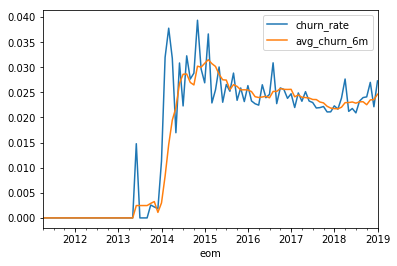

In [42]:
def _churn_rate(df):
    df["churn_rate"] = (df["cancelation_month"] / df["is_active"]).fillna(0)
    df["avg_churn_6m"] = df['churn_rate'].rolling(window=6).mean().fillna(0)
    return df


def _arpu_progression(df):
    df["avg_arpu_6m"] = df["initial_subscription_amt"].rolling(window=6).mean().fillna(0)
    return df


cdf = (
    cross_data
    .groupby("eom")
    .agg({
        'is_active': "sum",
        "starting_month": 'sum',
        'cancelation_month': 'sum',
        "initial_subscription_amt": "mean",
    })
    .pipe(_churn_rate)
    .pipe(_arpu_progression)
)
cdf.plot(y=["churn_rate", "avg_churn_6m"])
cdf.tail(10)

In [18]:
df.groupby(df["first_paying_date"].dt.strftime("%Y-%m")).agg({"initial_subscription_amt": "mean"}).rename(columns={"initial_subscription_amt": "arpu"})

,arpu
first_paying_date,
2011-04,65.000000
2011-05,38.000000
2011-10,43.000000
2011-11,47.000000
2011-12,52.000000
2012-01,59.000000
2012-02,37.000000
2012-03,32.000000
2012-04,38.000000


In [15]:
cdf

,is_active,starting_month,cancelation_month,churn_rate,avg_churn_6m
eom,,,,,
2011-04-30,0,1,0,0.000000,0.000000
2011-05-31,1,1,0,0.000000,0.000000
2011-06-30,2,0,0,0.000000,0.000000
2011-07-31,2,0,0,0.000000,0.000000
2011-08-31,2,0,0,0.000000,0.000000
2011-09-30,2,0,0,0.000000,0.000000
2011-10-31,2,1,0,0.000000,0.000000
2011-11-30,3,0,0,0.000000,0.000000
2011-12-31,3,1,0,0.000000,0.000000


In [14]:
churn = cdf['avg_churn_6m'].iloc[-1]
arpu = dtr["current_subscription_amt"].mean()
ltv_simple = arpu / churn
ltv_discounted = arpu / (churn + DISCOUNT_RATE)

initial_arpu_by_country = dtr.groupby("country").agg({"initial_subscription_amt": "mean"})
initial_arpu_by_industry = dtr.groupby("industry").agg({"initial_subscription_amt": "mean"})

In [15]:
res["c_traditional"] = churn
res["arpu_traditional"] = arpu
res["ltv_traditional"] = ltv_simple
res["ltv_discounted"] = ltv_discounted

## SBG

In [48]:
dtr.head()

,start_date,end_date,age,alive,country,industry,initial_subscription_amt,current_subscription_amt
account_id,,,,,,,,
8790,2014-01-01,2014-03-01,1,0,united_states,other_industryS,44.0,53.0
9858,2014-02-01,NaT,61,1,united_states,other_industryS,98.0,224.0
67622,2017-01-01,2017-04-01,3,0,united_states,other,77.0,77.0
30907,2015-04-01,2015-07-01,3,0,canada,other,80.0,89.0
71153,2017-02-01,NaT,24,1,united_states,lawn_care_&_lawn_maintenance,66.0,86.0


In [49]:
sbg = SBGSurvival(
    age='age',
    alive='alive',
    features=["country", "industry"],
    gamma=1e-3,
    verbose=False
)

In [51]:
# sbg.fit(dtr)
sbg.fit(dtr[dtr['start_date'] >= "2014-01-01"])

In [52]:
res["ltv_sbg"] = sbg.predict_ltv(dva, age=1, alive=1, arpu=dtr["initial_subscription_amt"].mean(), discount_rate=0.01)

## Main results

In [53]:
print("Traditional arpu/churn calculation leads to: ltv = {:.2f}".format(res["ltv_traditional"].mean()))

Traditional arpu/churn calculation leads to: ltv = 3784.31


In [54]:
print("Traditional arpu/churn calculation leads to: ltv = {:.2f}".format(res["ltv_discounted"].mean()))

Traditional arpu/churn calculation leads to: ltv = 2674.35


In [55]:
print("Traditional arpu/churn calculation leads to: ltv = {:.2f}".format(res["ltv_sbg"].mean()))

Traditional arpu/churn calculation leads to: ltv = 3726.22


# Retention Curves

In [56]:
%%time
cross_data_va = cross_join(dva.reset_index()[["account_id", "start_date", "end_date"]], months)
cross_data_va = cross_data_va[cross_data_va["eom"] >= cross_data_va["start_date"]]

cross_data_va["age"] = cross_data_va.apply(_age, axis=1)
cross_data_va["is_active"] = cross_data_va.apply(_is_active, axis=1)
cross_data_va["starting_month"] = cross_data_va.apply(_starting_month, axis=1)
cross_data_va["cancelation_month"] = cross_data_va.apply(_cancelation_month, axis=1)

CPU times: user 18.3 s, sys: 130 ms, total: 18.5 s
Wall time: 18.5 s


In [57]:
def _normalize(df):
    return df / df.iloc[0]


cohort_retention = (
    cross_data_va[cross_data_va['is_active'] == 1]
    .merge(dva.reset_index()[["account_id"]], on="account_id")
    .groupby(['start_date', 'age'])
    .agg({"is_active": 'sum'})
    .unstack("start_date")
    .pipe(_normalize)
    .loc[:, ("is_active", "2014-01-01"):]
    .dropna(how="all")
)

In [58]:
retention = sbg.predict_survival(dva, age=1, n_periods=cohort_retention.shape[1])
retention_matrix = retention.unstack("age")
retention_matrix.columns = [i for i in range(1, retention_matrix.shape[1] + 1)]

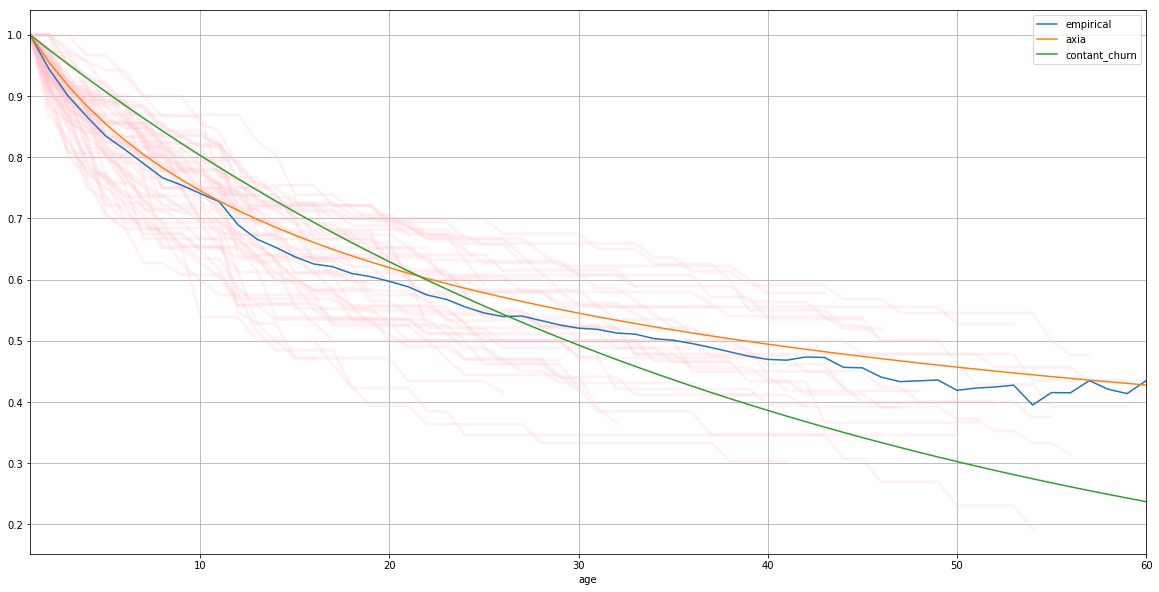

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))


cohort_retention.plot(ax=ax, alpha=0.2, c="pink", linewidth=3, legend=False)

cohort_retention.mean(axis=1).plot(ax=ax, label='empirical', legend=True)
retention_matrix.mean().plot(label="axia", legend=True)
pd.DataFrame([1 * (1 - churn) ** i for i in range(0, cohort_retention.shape[0])], columns=["contant_churn"], index=pd.Series(range(1, cohort_retention.shape[0] + 1), name='age')).plot(ax=ax)


ax.grid(True)

In [27]:
def _normalize_cohort_ltv(df):
    return df["current_subscription_amt"].cumsum() / df["is_active"].iloc[0]
    

cohort_ltv = (
    cross_data_va[cross_data_va['is_active'] == 1]
    .merge(dva.reset_index()[["account_id", "current_subscription_amt"]], on="account_id")
    .groupby(['start_date', 'age'])
    .agg({'current_subscription_amt': "sum", "is_active": "sum"})
    .loc["2014-01-01":]
    .unstack("start_date")
    .pipe(_normalize_cohort_ltv)
    .dropna(how="all")
)

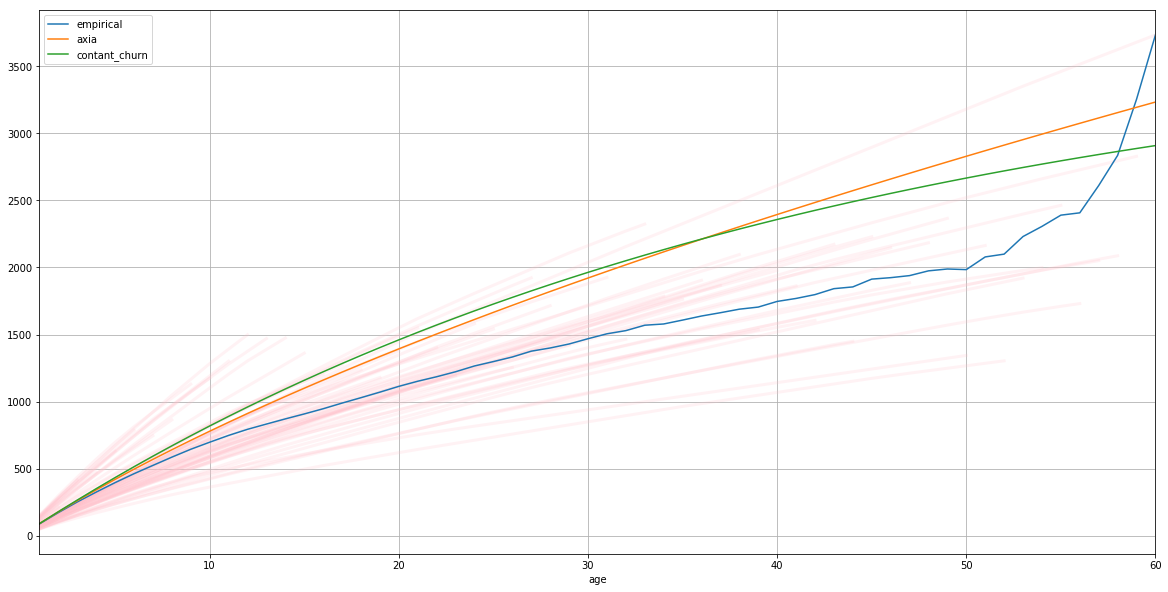

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))


cohort_ltv.plot(ax=ax, alpha=0.2, c="pink", linewidth=3, legend=False)

cohort_ltv.mean(axis=1).plot(ax=ax, label='empirical', legend=True)
(retention_matrix * arpu).cumsum(axis=1).mean().plot(label="axia", legend=True)
pd.DataFrame(
    data=[arpu * (1 - churn) ** i for i in range(0, cohort_retention.shape[0])],
    columns=["contant_churn"],
    index=pd.Series(range(1, cohort_retention.shape[0] + 1), name='age')
).cumsum().plot(ax=ax)


ax.grid(True)

# Prediction Log-Loss

In [29]:
from sklearn.metrics import log_loss

In [30]:
r = retention.copy()
r["1_c"] = r.index.map(lambda ind: 1 * (1 - churn) ** ind[1]).values

In [31]:
cva = cross_data_va.set_index(["account_id", "age"]).join(r, how="inner").sort_index()

In [32]:
log_loss(cva['is_active'].fillna(0).values, cva["probability"].values)

1.7572412379452638

In [33]:
log_loss(cva['is_active'].fillna(0).values, cva["1_c"].values)

1.778082434524989

# Stratifying

### Country

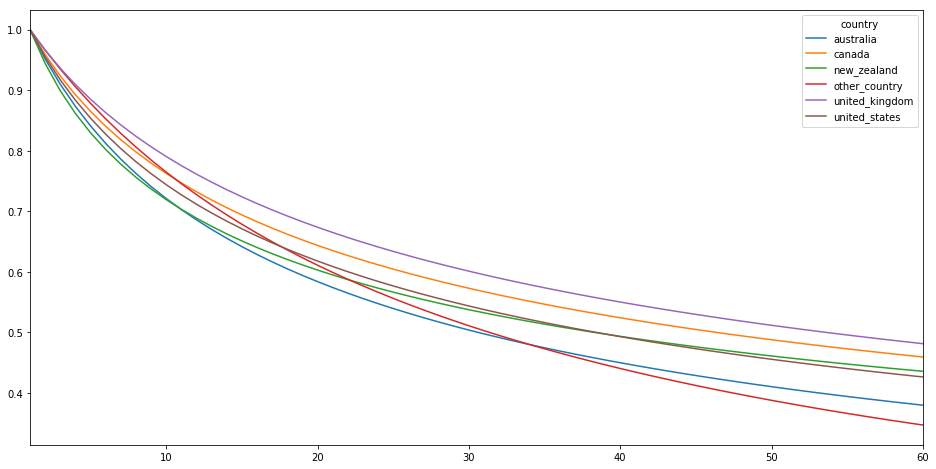

In [34]:
retention_matrix.groupby(dva['country']).mean().T.plot(figsize=(16, 8))

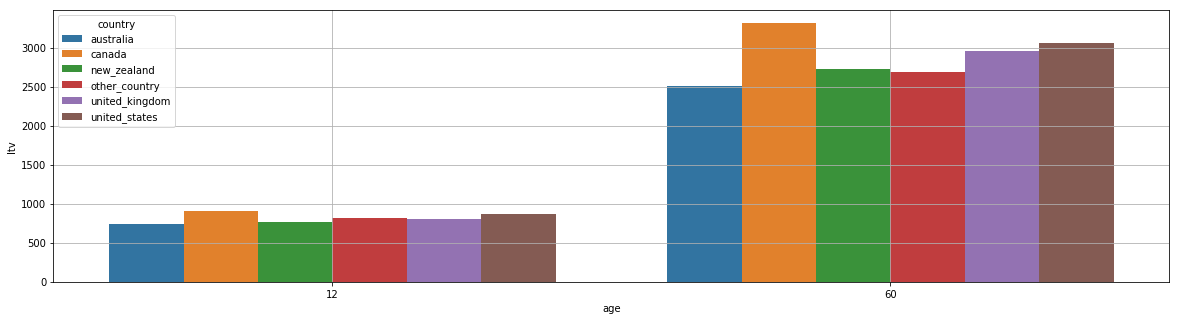

In [35]:
_, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.barplot(
    x="age",
    y="ltv",
    hue="country",
    data=(
        (
            retention_matrix
            .groupby(dva['country'])
            .mean()
            .T *
            initial_arpu_by_country
            .T
            .values[0]
        ).cumsum()
        .iloc[[11, -1]]
        .T
        .stack()
        .reset_index()
        .rename(columns={"level_1": "age", 0: 'ltv'})
    ),
    ax=ax,
)
ax.grid(True)

In [62]:
(
    (
        retention_matrix
        .groupby(dva['country'])
        .median()
        .T *
        initial_arpu_by_country
        .T
        .values[0]
    ).cumsum()
    .iloc[[11, -1]]
    .T
    .sort_values(60, ascending=False)
    .join(
        retention_matrix.groupby(dva['country']).mean().T.iloc[[11, -1]].T,
        lsuffix="_months_ltv",
        rsuffix="_months_retention",
    )
)

,12_months_ltv,60_months_ltv,12_months_retention,60_months_retention
country,,,,
canada,914.500216,3288.890464,0.727561,0.461784
united_states,871.130791,3030.299047,0.709180,0.423092
united_kingdom,798.817386,2892.888493,0.757494,0.483702
new_zealand,760.622951,2709.499216,0.681847,0.429300
other_country,814.777664,2577.343984,0.724268,0.339497
australia,745.864056,2507.721380,0.681515,0.368162


### Industry

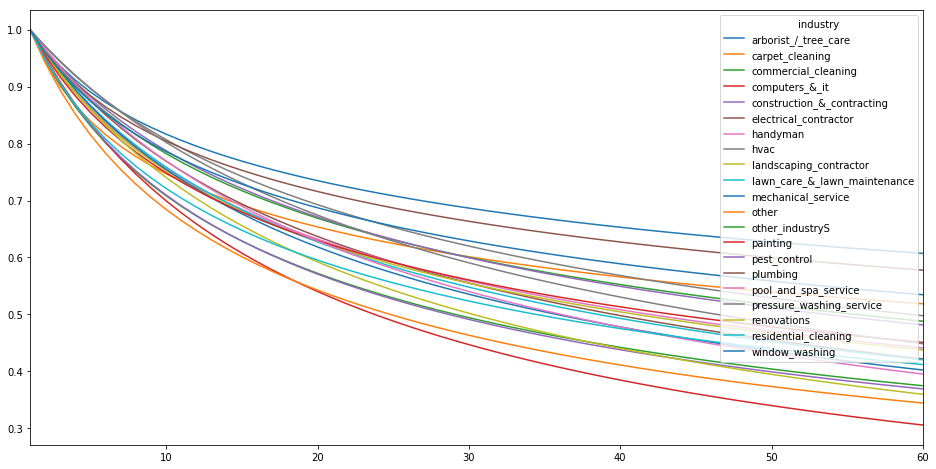

In [37]:
retention_matrix.groupby(dva['industry']).mean().T.plot(figsize=(16, 8))

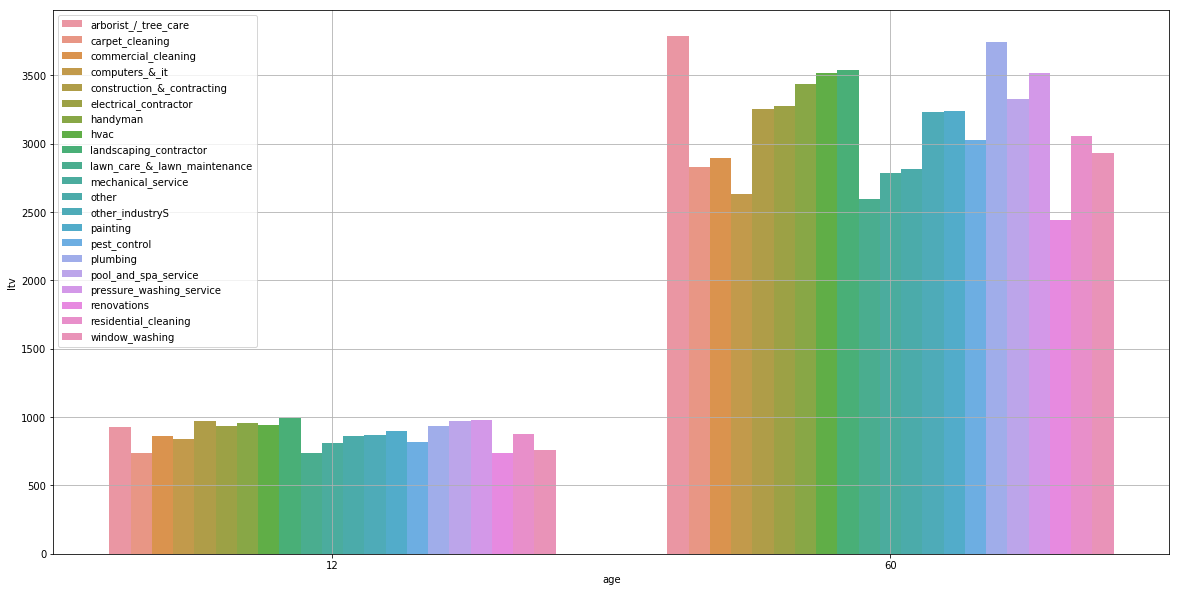

In [38]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.barplot(
    x="age",
    y="ltv",
    hue="industry",
    data=(
        (
            retention_matrix
            .groupby(dva['industry'])
            .mean()
            .T *
            initial_arpu_by_industry
            .T
            .values[0]
        ).cumsum()
        .iloc[[11, -1]]
        .T
        .stack()
        .reset_index()
        .rename(columns={"level_1": "age", 0: 'ltv'})
    ),
    ax=ax,
)
ax.grid(True)
ax.legend(loc=2)

In [39]:
(
    (
        retention_matrix
        .groupby(dva['industry'])
        .mean()
        .T *
        initial_arpu_by_industry
        .T
        .values[0]
    ).cumsum()
    .iloc[[11, -1]]
    .T
    .sort_values(60, ascending=False)
    .join(
        retention_matrix.groupby(dva['industry']).mean().T.iloc[[11, -1]].T,
        lsuffix="_months_ltv",
        rsuffix="_months_retention",
    )
)

,12_months_ltv,60_months_ltv,12_months_retention,60_months_retention
industry,,,,
arborist_/_tree_care,929.041856,3787.524298,0.795422,0.607208
plumbing,937.818390,3745.448230,0.781486,0.577738
landscaping_contractor,991.838090,3537.508710,0.720679,0.437772
pressure_washing_service,978.266222,3519.264890,0.771121,0.448520
hvac,940.006424,3518.691676,0.778713,0.497747
handyman,959.943381,3434.507190,0.724206,0.441188
pool_and_spa_service,971.245100,3330.279083,0.734847,0.395239
electrical_contractor,933.567930,3279.226187,0.736062,0.421827
construction_&_contracting,972.584804,3252.969789,0.673525,0.369235
